# generating embeddings with model trained with cls-pooling vs Xpressor layers


In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scprint.tasks import GeneEmbeddingExtractor
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scipy.stats import spearmanr
from anndata import AnnData

from grnndata.utils import TF, file_dir
import gseapy as gp

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/" #"../..data/"  #

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/lamindb/core/storage/_anndata_accessor.py:12: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/lamindb/core/storage/_zarr.py:6: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [1]:
adata = sc.read(
    LOC + "temp/glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

max_len = 4000 if adata.X.sum(1).mean() < 10_000 else 8000
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=True,
)
print("")
print(adata.X.sum(1).mean())
adata = preprocessor(adata)


388362.5
Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 3567 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_o

In [ ]:
m = torch.load(model_checkpoint_file, map_location="cpu")

In [ ]:
m["hyper_parameters"]["label_decoders"] = {
    k: {u: j if j is not None else "None" for u, j in v.items()}
    for k, v in m["hyper_parameters"]["label_decoders"].items()
}

In [ ]:
rn = {
    "expr_encoder.encoder.2.weight": "expr_encoder.encoder.1.weight",
    "expr_encoder.encoder.2.bias": "expr_encoder.encoder.1.bias",
    "expr_encoder.encoder.6.weight": "expr_encoder.encoder.5.weight",
    "expr_encoder.encoder.6.bias": "expr_encoder.encoder.5.bias",
    "expr_decoder.fc.2.weight": "expr_decoder.fc.1.weight",
    "expr_decoder.fc.2.bias": "expr_decoder.fc.1.bias",
    "expr_decoder.fc.6.weight": "expr_decoder.fc.5.weight",
    "expr_decoder.fc.6.bias": "expr_decoder.fc.5.bias",
}
m["state_dict"] = {k if k not in rn else rn[k]: v for k, v in m["state_dict"].items()}

m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("residual_in_fp32")
m["hyper_parameters"].pop("fused_dropout_add_ln")
m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("fused_mlp")
m["hyper_parameters"].pop("fused_bias_fc")
m["hyper_parameters"].pop("drop_path_rate")
m["hyper_parameters"].pop("class_compression")
m["hyper_parameters"].pop("depth_atinput")
m["hyper_parameters"].pop("cell_transformer_layers")
m["hyper_parameters"].pop("residual_in_fp32")

In [ ]:
torch.save(m, model_checkpoint_file)

In [36]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
LOC2 = "../"  # "../../../"
model_checkpoint_file = LOC2 + "models/18hebyht-final-small.ckpt"
# model_checkpoint_file = "../../../psqzicou.ckpt"
# w937u4o1

In [37]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [8]:
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1842
neoplastic cell                   1079
oligodendrocyte precursor cell     406
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            50
neuron                              21
Name: count, dtype: int64

In [63]:
cell_type = "vascular lymphangioblast"
extractor = GeneEmbeddingExtractor(
    genelist=adata.var.index[
        np.array(
            (adata[adata.obs.cell_type == cell_type].X > 0).sum(0)
            > (adata.obs.cell_type.value_counts()[cell_type] * 0.3)
        )[0]
    ].tolist(),
    batch_size=16,
    num_workers=8,
    average=False,
)

# model 1


In [64]:
gemb_da = extractor(model, adata[adata.obs.cell_type == cell_type, :][:2])

Using 100.00% of the genes in the gene list


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


In [65]:
gemb_da.varm["gene_embeddings"] = gemb_da.uns["all_embeddings"][0]

In [66]:
gemb_da = gemb_da.T

In [67]:
gemb_da.obsm["gene_pca"] = sc.pp.pca(
    gemb_da.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [68]:
sc.tl.umap(
    gemb_da,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [69]:
genes = load_genes(["NCBITaxon:9606"])

In [70]:
gemb_da.obs = genes.loc[gemb_da.obs.index]

In [71]:
gemb_da.obs["expression"] = np.log(1 + gemb_da.X[:, 0])
gemb_da.obs["zero_expression"] = gemb_da.X[:, 0] == 0

In [72]:
sc.tl.leiden(
    gemb_da,
    neighbors_key="gene_neighbors",
    resolution=1.0,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

... storing 'biotype' as categorical
... storing 'organism' as categorical


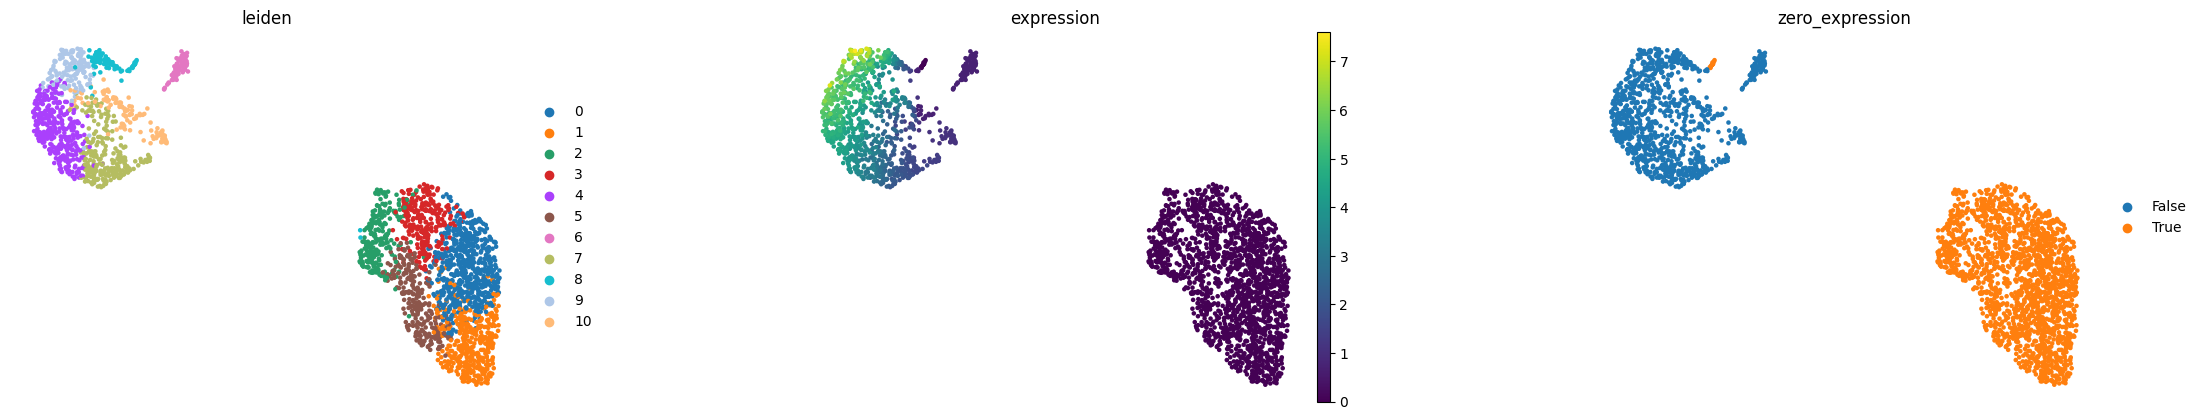

In [73]:
sc.pl.umap(
    gemb_da,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)

In [ ]:
# lots of PPI hub and chromosome location, mircro<RNA, TF chip-seq 2 GO MF, 1 GO CC Nucleus

In [74]:
for gs in [
    "KEGG_2021_Human",
    "GO_Molecular_Function_2025",
    "WikiPathways_2024_Human",
    "GO_Cellular_Component_2025",
]:
    elems = 0
    for cluster in gemb_da.obs["leiden"].cat.categories:

        pre_res = gp.enrich(
            gene_list=gemb_da.obs.symbol[
                gemb_da.obs["leiden"] == cluster
            ].tolist(),  # or rnk = rnk,
            gene_sets=gs,
            background=gemb_da.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
            outdir=None,
            verbose=True,
        )

        elems += len(pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05])
    print(gs, elems)

2025-11-02 16:54:45,172 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:46,279 [INFO] Done.
2025-11-02 16:54:46,897 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:48,052 [INFO] Done.
2025-11-02 16:54:48,581 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:49,641 [INFO] Done.
2025-11-02 16:54:50,208 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:51,273 [INFO] Done.
2025-11-02 16:54:51,839 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:52,897 [INFO] Done.
2025-11-02 16:54:53,451 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:54,506 [INFO] Done.
2025-11-02 16:54:55,037 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:56,086 [INFO] Done.
2025-11-02 16:54:56,633 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:57,686 [INFO] Done.
2025-11-02 16:54:58,234 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:54:59,203 [INFO] Done.
2025-11-02 16:54:59,753 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:55:00,812 [INFO] Done.
2025-11-02 16:55:01,356 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:55:02,404 [INFO] Done.


KEGG_2021_Human 85


2025-11-02 16:55:02,964 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:04,114 [INFO] Done.
2025-11-02 16:55:04,647 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:05,783 [INFO] Done.
2025-11-02 16:55:06,359 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:07,463 [INFO] Done.
2025-11-02 16:55:08,016 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:09,172 [INFO] Done.
2025-11-02 16:55:09,744 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:10,885 [INFO] Done.
2025-11-02 16:55:11,439 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:12,570 [INFO] Done.
2025-11-02 16:55:13,147 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:14,195 [INFO] Done.
2025-11-02 16:55:14,731 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:15,843 [INFO] Done.
2025-11-02 16:55:16,398 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:17,457 [INFO] Done.
2025-11-02 16:55:18,020 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:55:19,054 [IN

GO_Molecular_Function_2025 24


2025-11-02 16:55:21,231 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:22,456 [INFO] Done.
2025-11-02 16:55:23,027 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:24,154 [INFO] Done.
2025-11-02 16:55:24,725 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:25,843 [INFO] Done.
2025-11-02 16:55:26,402 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:27,554 [INFO] Done.
2025-11-02 16:55:28,125 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:29,240 [INFO] Done.
2025-11-02 16:55:29,798 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:30,929 [INFO] Done.
2025-11-02 16:55:31,498 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:32,547 [INFO] Done.
2025-11-02 16:55:33,102 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:34,239 [INFO] Done.
2025-11-02 16:55:34,811 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:35,838 [INFO] Done.
2025-11-02 16:55:36,369 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:55:37,500 [INFO] Done.
2025-11-02 16:55:38,

WikiPathways_2024_Human 68


2025-11-02 16:55:39,663 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:40,808 [INFO] Done.
2025-11-02 16:55:41,364 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:42,458 [INFO] Done.
2025-11-02 16:55:43,021 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:44,072 [INFO] Done.
2025-11-02 16:55:44,626 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:45,645 [INFO] Done.
2025-11-02 16:55:46,196 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:47,320 [INFO] Done.
2025-11-02 16:55:47,878 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:48,904 [INFO] Done.
2025-11-02 16:55:49,456 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:50,494 [INFO] Done.
2025-11-02 16:55:51,050 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:52,103 [INFO] Done.
2025-11-02 16:55:52,667 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:53,692 [INFO] Done.
2025-11-02 16:55:54,264 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:55:55,303 [IN

GO_Cellular_Component_2025 45


In [90]:
from scipy.stats import ttest_ind, ttest_rel
import pandas as pd

cols = ["xpressor_generator", "no_xpressor"]
data = {
    "GO_Cellular_Component_2025": [41, 20],
    "WikiPathways_2024_Human": [20, 23],
    "GO_Molecular_Function_2025": [15, 2],
    "KEGG_2021_Human": [72, 23],
    "GO_Cellular_Component_2025_2": [37, 28],
    "WikiPathways_2024_Human_2": [8, 1],
    "GO_Molecular_Function_2025_2": [12, 16],
    "KEGG_2021_Human_2": [36, 16],
    "GO_Cellular_Component_2025_3": [85, 19],
    "WikiPathways_2024_Human_3": [24, 4],
    "GO_Molecular_Function_2025_3": [68, 8],
    "KEGG_2021_Human_3": [45, 17],
}

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, index=cols).T

# Paired t-test (since comparing same gene sets)
t_stat, p_value = ttest_rel(df["xpressor_generator"], df["no_xpressor"])

print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Independent t-test (if you prefer)
t_stat_ind, p_value_ind = ttest_ind(df["xpressor_generator"], df["no_xpressor"])

print(f"\nIndependent t-test results:")
print(f"t-statistic: {t_stat_ind:.4f}")
print(f"p-value: {p_value_ind:.4f}")

# Summary statistics
print(f"\nMean enrichments:")
print(
    f"Xpressor generator: {df['xpressor_generator'].mean():.2f} ± {df['xpressor_generator'].std():.2f}"
)
print(f"No xpressor: {df['no_xpressor'].mean():.2f} ± {df['no_xpressor'].std():.2f}")

Paired t-test results:
t-statistic: 3.5680
p-value: 0.0044

Independent t-test results:
t-statistic: 3.0951
p-value: 0.0053

Mean enrichments:
Xpressor generator: 38.58 ± 25.13
No xpressor: 14.75 ± 8.94


# second model without XPressor


In [49]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
LOC2 = "../"  # "../../../"
model_checkpoint_file = LOC2 + "models/z3abxa21-nogen.ckpt"
# model_checkpoint_file = "../../../psqzicou.ckpt"
# ogvvg2z7-v1
# w937u4o1

In [50]:
model2 = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model2 = model2.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [ ]:
gemb_da_2 = extractor(model2, adata[adata.obs.cell_type == cell_type, :][:2])

Using 100.00% of the genes in the gene list


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


In [ ]:
gemb_da_2.varm["gene_embeddings"] = gemb_da_2.uns["all_embeddings"].mean(0)

In [77]:
gemb_da_2 = gemb_da_2.T

In [78]:
gemb_da_2.obsm["gene_pca"] = sc.pp.pca(
    gemb_da_2.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da_2,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [79]:
sc.tl.umap(
    gemb_da_2,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [80]:
genes = load_genes(["NCBITaxon:9606"])

In [86]:
gemb_da_2.obs = genes.loc[gemb_da_2.obs.index]

In [87]:
gemb_da_2.obs["expression"] = np.log(1 + gemb_da_2.X[:, 0])
gemb_da_2.obs["zero_expression"] = gemb_da_2.X[:, 0] == 0

In [88]:
sc.tl.leiden(
    gemb_da_2,
    neighbors_key="gene_neighbors",
    resolution=1.0,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

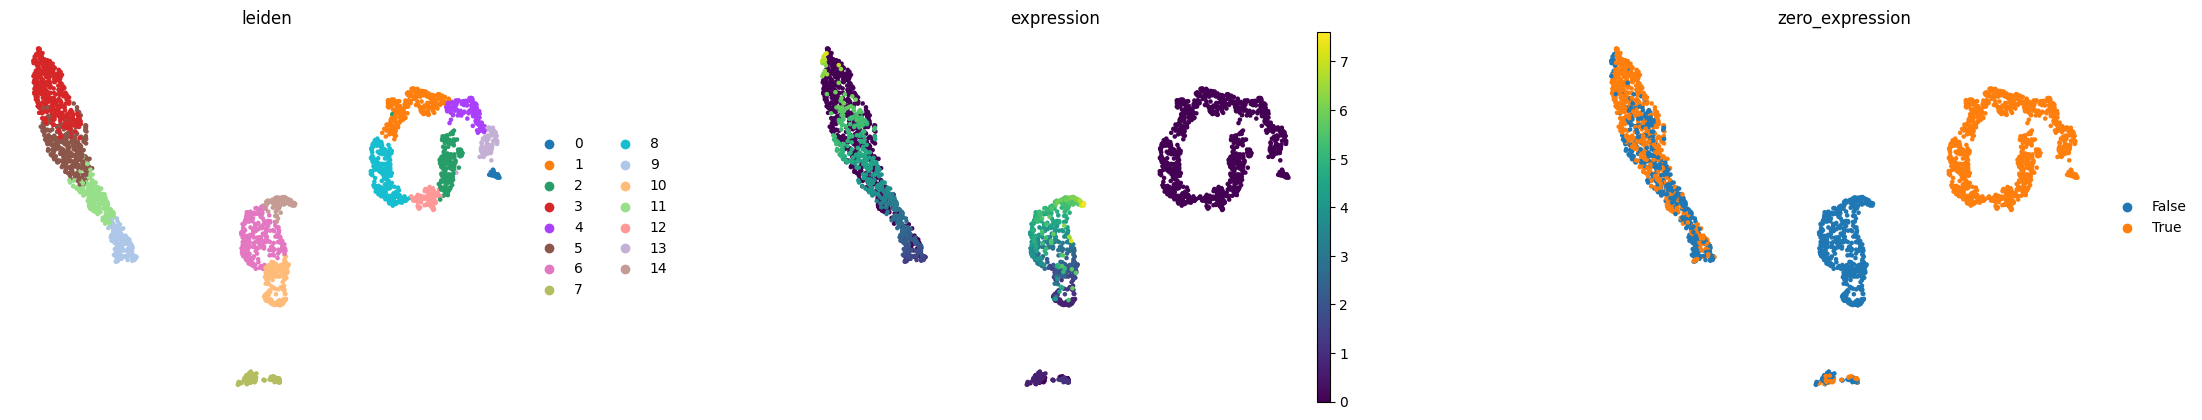

In [84]:
sc.pl.umap(
    gemb_da_2,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)  # mean of all

0 go MF, 0 CC, 0 TF chip seq...


In [89]:
for gs in [
    "KEGG_2021_Human",
    "GO_Molecular_Function_2025",
    "WikiPathways_2024_Human",
    "GO_Cellular_Component_2025",
]:
    elems = 0
    for cluster in gemb_da_2.obs["leiden"].cat.categories:

        pre_res = gp.enrich(
            gene_list=gemb_da_2.obs.symbol[
                gemb_da_2.obs["leiden"] == cluster
            ].tolist(),  # or rnk = rnk,
            gene_sets=gs,
            background=gemb_da_2.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
            outdir=None,
            verbose=True,
        )

        elems += len(pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05])
    print(gs, elems)

2025-11-02 16:59:50,206 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:51,189 [INFO] Done.
2025-11-02 16:59:51,837 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:52,872 [INFO] Done.
2025-11-02 16:59:53,432 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:54,443 [INFO] Done.
2025-11-02 16:59:54,990 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:56,120 [INFO] Done.
2025-11-02 16:59:56,684 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:57,737 [INFO] Done.
2025-11-02 16:59:58,306 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:59:59,367 [INFO] Done.
2025-11-02 16:59:59,940 [INFO] Run: KEGG_2021_Human 
2025-11-02 17:00:00,973 [INFO] Done.
2025-11-02 17:00:01,529 [INFO] Run: KEGG_2021_Human 
2025-11-02 17:00:02,694 [INFO] Done.
2025-11-02 17:00:03,278 [INFO] Run: KEGG_2021_Human 
2025-11-02 17:00:04,650 [INFO] Done.
2025-11-02 17:00:05,199 [INFO] Run: KEGG_2021_Human 
2025-11-02 17:00:06,239 [INFO] Done.
2025-11-02 17:00:06,793 [INFO] Run: KEGG_2021_Human 
2025-11-02 17:00:07,844 [INFO] Done.
2025-11-02

KEGG_2021_Human 19


2025-11-02 17:00:14,786 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:15,731 [INFO] Done.
2025-11-02 17:00:16,289 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:17,416 [INFO] Done.
2025-11-02 17:00:17,952 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:18,981 [INFO] Done.
2025-11-02 17:00:19,528 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:20,644 [INFO] Done.
2025-11-02 17:00:21,204 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:22,250 [INFO] Done.
2025-11-02 17:00:22,794 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:23,922 [INFO] Done.
2025-11-02 17:00:24,490 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:25,627 [INFO] Done.
2025-11-02 17:00:26,196 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:27,244 [INFO] Done.
2025-11-02 17:00:27,782 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:28,928 [INFO] Done.
2025-11-02 17:00:29,470 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 17:00:30,585 [IN

GO_Molecular_Function_2025 4


2025-11-02 17:00:39,284 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:40,302 [INFO] Done.
2025-11-02 17:00:40,855 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:41,979 [INFO] Done.
2025-11-02 17:00:42,537 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:43,633 [INFO] Done.
2025-11-02 17:00:44,200 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:45,301 [INFO] Done.
2025-11-02 17:00:45,832 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:46,955 [INFO] Done.
2025-11-02 17:00:47,511 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:48,617 [INFO] Done.
2025-11-02 17:00:49,148 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:50,240 [INFO] Done.
2025-11-02 17:00:50,771 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:51,906 [INFO] Done.
2025-11-02 17:00:52,434 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:53,560 [INFO] Done.
2025-11-02 17:00:54,115 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 17:00:55,257 [INFO] Done.
2025-11-02 17:00:55,

WikiPathways_2024_Human 8


2025-11-02 17:01:04,023 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:05,070 [INFO] Done.
2025-11-02 17:01:05,635 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:06,700 [INFO] Done.
2025-11-02 17:01:07,259 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:08,318 [INFO] Done.
2025-11-02 17:01:08,867 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:09,997 [INFO] Done.
2025-11-02 17:01:10,562 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:11,613 [INFO] Done.
2025-11-02 17:01:12,171 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:13,300 [INFO] Done.
2025-11-02 17:01:13,862 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:14,896 [INFO] Done.
2025-11-02 17:01:15,448 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:16,485 [INFO] Done.
2025-11-02 17:01:17,049 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:18,193 [INFO] Done.
2025-11-02 17:01:18,737 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 17:01:19,775 [IN

GO_Cellular_Component_2025 17


... storing 'biotype' as categorical
... storing 'organism' as categorical


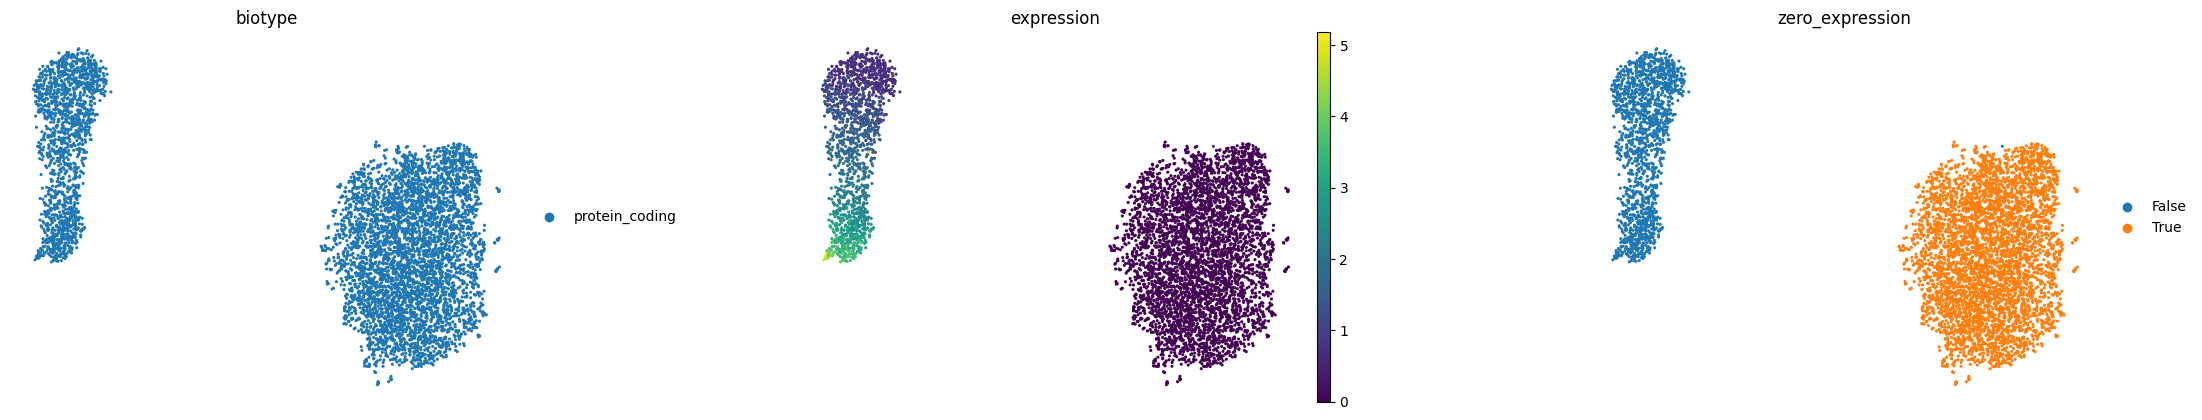

In [42]:
sc.pl.umap(
    gemb_da_2,
    color=["biotype", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)